In [157]:
import math
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
!pip install graphviz
%matplotlib inline

Reshimming asdf python...


In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

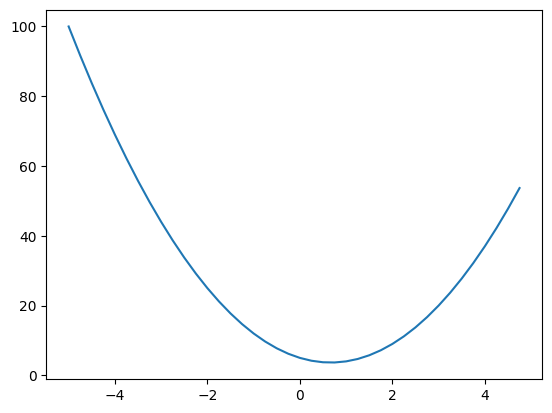

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [12]:
h = 0.000001
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [13]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)


4.0


In [431]:
h = 0.000001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
b += h
print('d1', d1)
d2 = a * b + c
print('d2', d2)
slope = (d2 - d1) / h
print('slope', slope)



d1 4.0
d2 4.000002
slope 2.000000000279556


In [142]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._op = _op
    self._label = label
    self._prev = set(_children)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build(child)
        topo.append(v)
    g = build(self)
    self.grad = 1.0
    for v in reversed(topo):
      v._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e._label = 'e'
d = e + c; d._label = 'd'
f = Value(-2.0, label='f')
L = d * f; L._label = 'L'

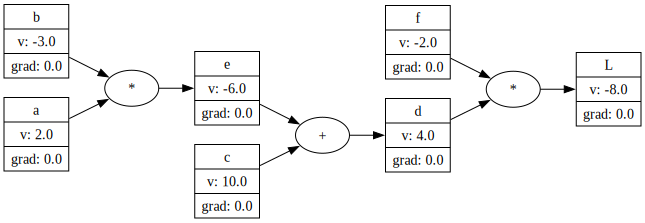

In [89]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label=f'{n._label} | v: {str(n.data)} | grad: {str(n.grad)}', shape='record')
    if n._op:
      dot.node(uid + n._op, n._op)
      dot.edge(uid + n._op, uid)
  for a, b in edges:
    dot.edge(str(id(a)), str(id(b)) + b._op)
  return dot


draw_dot(L)

In [68]:
def lol():
  h = 0.000001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e._label = 'e'
  d = e + c; d._label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L._label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0 + h, label='b')
  c = Value(10.0, label='c')
  e = a * b; e._label = 'e'
  d = e + c; d._label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L._label = 'L'
  L2 = L.data
  print((L2 - L1) / h)

lol()

-4.000000000559112


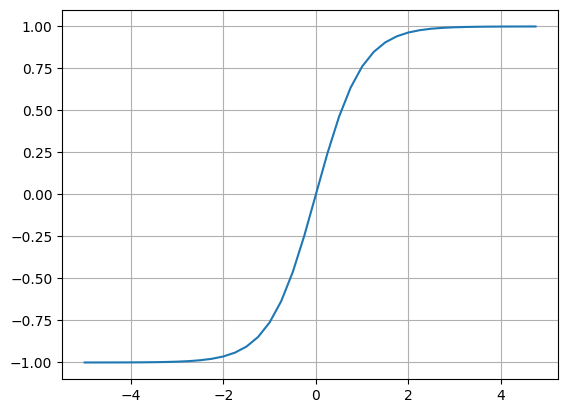

In [69]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))
plt.grid()
plt.show()


In [111]:
# Inputs of the neurons
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights of the neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neurons
b = Value(6.881373587019543, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'
print(x1)
o = n.tanh(); o._label = 'o'


Value(data=2.0)


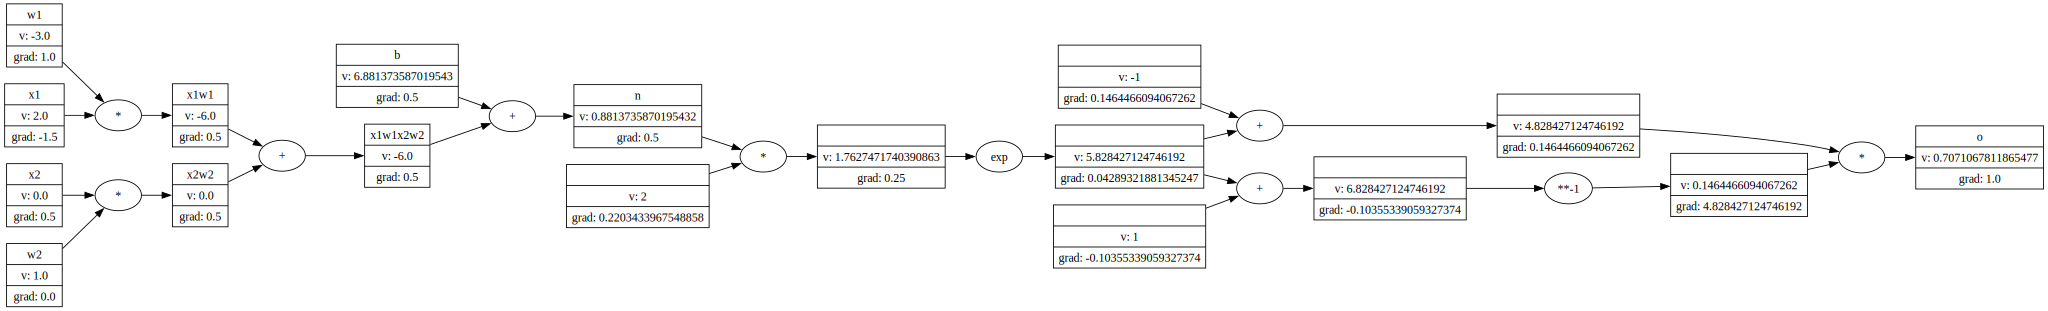

In [147]:
# Inputs of the neurons
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights of the neurons
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neurons
b = Value(6.881373587019543, label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1x2w2'
n = x1w1x2w2 + b; n._label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
# o = n.tanh();
o._label = 'o'
o.backward()
draw_dot(o)


In [154]:
import torch

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.881373587019543, requires_grad=True)

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())

o.backward()

print(x1.grad)
print(x2.grad)
print(w1.grad)
print(w2.grad)
o.item()

0.7071067094802856
tensor(-1.5000)
tensor(0.5000)
tensor(1.0000)
tensor(0.)


0.7071067094802856

In [245]:
class Neuron:
  def __init__(self, number_of_inputs):
    # number of inputs is sometimes called the dimensions of the neuron
    # E.g. n = Neuron(3) means it's a 3-dimensional neuron
    self.w = [Value(random.uniform(-1, 1)) for _ in range(number_of_inputs)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # This is the raw activation:
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, number_of_inputs, number_of_outputs):
    self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_outputs)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
  def __init__(self, number_of_inputs, sizes_of_layers):
    sz = [number_of_inputs] + sizes_of_layers
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [424]:
n = MLP(3, [4, 4, 1])

xs = [
  [2.0, 3.0, -1],
  [3, -1, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, -1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8672839927478093),
 Value(data=0.2698520790621686),
 Value(data=-0.8031568870703744),
 Value(data=-0.873830648314921)]

In [429]:
for k in range(25):
  # Forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

  # Backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # Update weights
  for p in n.parameters():
    p.data += -0.05 * p.grad

  # Print loss
  print(loss.data)



0.048973599426947054
0.047290087833560465
0.045706742621221264
0.04421534927311753
0.04280853598053368
0.04147967120098789
0.04022277546930176
0.03903244524632934
0.03790378696784519
0.03683235976416184
0.035814125573182864
0.03484540557665776
0.033922842060045
0.03304336493747354
0.03220416230032386
0.031402654445334965
0.030636470919434403
0.029903430186540163
0.029201521578735193
0.02852888924232743
0.02788381782994781
0.02726471972423771
0.026670123607884386
0.026098664219618893
0.02554907315699838


In [407]:
loss.backward()

In [408]:

for p in n.parameters():
  p.data += -0.01 * p.grad

In [430]:
ypred

[Value(data=0.8893518880624546),
 Value(data=-0.9931298016244079),
 Value(data=-0.9323706056513746),
 Value(data=-0.9068059343307047)]

In [444]:
n = Neuron(3)

print(n([1.0, 2.0, 3.0]))


Value(data=0.5341107763147889)
